In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [2]:
ImageSize = 256
BatchSize = 32
channels = 3
epochs = 50

## Import Data

In [4]:
data = tf.keras.preprocessing.image_dataset_from_directory(
    "potato-images", shuffle = True, image_size = (ImageSize, ImageSize), batch_size = BatchSize
)

Found 2152 files belonging to 3 classes.


In [6]:
class_names = data.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

each element in the dataset is a tuple. First element is a batch of 32 elements of images. Second element is a batch of 32 elements of class labels

In [8]:
for image_batch, labels_batch in data.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[0 1 0 1 1 0 1 1 0 0 2 0 1 1 0 0 0 1 0 0 0 0 1 0 0 1 1 0 0 0 0 1]


## Visualize some images

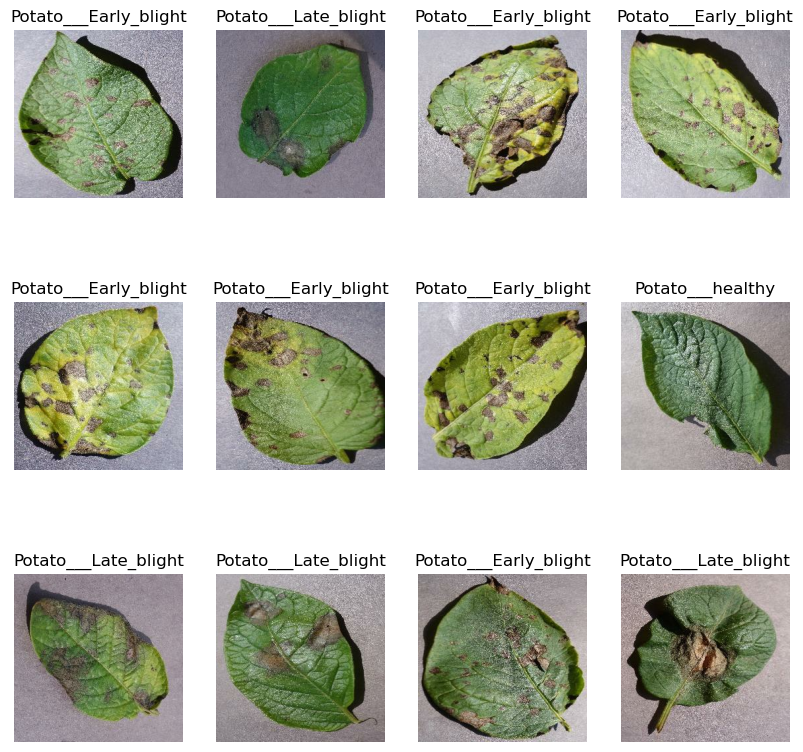

In [9]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in data.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

## Training Testing split- 
- training (80%)
- validation (10%)
- test (10%)

In [10]:
len(data)

68

In [12]:
train_size = 0.8
len(data)*train_size

54.400000000000006

in tensorflow there is nothing like train_test_split function. here we have data.take() function to take that many samples from data so we will take 80% of total data size ie 68 for training data

In [13]:
train_data = data.take(54)
len(train_data)

54

In [18]:
test = data.skip(54)
# skip(54) is like 54 onwards
len(test)

14

In [15]:
val_size = 0.1
len(data)*val_size

6.800000000000001

In [21]:
val_data = test.take(7)
len(val_data)

7

In [22]:
test_data = test.skip(7)
len(test_data)

7

so to do all above splitting we can just implement a method as below

In [3]:
def train_test_split(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [26]:
train_data, val_data, test_data = train_test_split(data)

In [27]:
print(len(train_data), len(val_data), len(test_data))

54 6 8


## Cache, Shuffle, and Prefetch the Dataset

In [29]:
train_data = train_data.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_data = val_data.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_data = test_data.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

now the data is optimized. so it will be trained fast

## Building Model

- resizing and rescaling images (256x256 and range 255->1)
- data augmentation (aplly multiple filer on an image and take all filtered images for training, so we get robust dataset)

In [4]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(ImageSize, ImageSize),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [5]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [32]:
train_data = train_data.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

a CNN coupled with a Softmax activation in the output layer. We also add the initial layers for resizing, normalization and Data Augmentation.

In [34]:
input_shape = (BatchSize, ImageSize, ImageSize, channels)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [35]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (32, 127, 127, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 62, 62, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (32, 60, 60, 64)         

In [36]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [37]:
history = model.fit(
    train_data,
    batch_size=BatchSize,
    validation_data=val_data,
    verbose=1,
    epochs=50,
)

Epoch 1/50
54/54 [==============================] - 169s 3s/step - loss: 0.9032 - accuracy: 0.4913 - val_loss: 0.9513 - val_accuracy: 0.4323
Epoch 2/50
54/54 [==============================] - 146s 3s/step - loss: 0.7369 - accuracy: 0.6609 - val_loss: 0.9547 - val_accuracy: 0.6354
Epoch 3/50
54/54 [==============================] - 129s 2s/step - loss: 0.5567 - accuracy: 0.7691 - val_loss: 0.5668 - val_accuracy: 0.7604
Epoch 4/50
54/54 [==============================] - 125s 2s/step - loss: 0.4202 - accuracy: 0.8304 - val_loss: 0.3449 - val_accuracy: 0.8229
Epoch 5/50
54/54 [==============================] - 156s 3s/step - loss: 0.2733 - accuracy: 0.8981 - val_loss: 0.8278 - val_accuracy: 0.7083
Epoch 6/50
54/54 [==============================] - 142s 3s/step - loss: 0.2062 - accuracy: 0.9155 - val_loss: 0.5997 - val_accuracy: 0.8177
Epoch 7/50
54/54 [==============================] - 110s 2s/step - loss: 0.2584 - accuracy: 0.9086 - val_loss: 0.5519 - val_accuracy: 0.8229
Epoch 8/50
54

In [38]:
scores = model.evaluate(test_data)

8/8 [==============================] - 4s 293ms/step - loss: 0.0159 - accuracy: 0.9922


## Plotting the Accuracy and Loss Curves

In [39]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 54}

In [40]:
history.history['loss'][:5] # show loss for first 5 epochs

[0.9032375812530518,
 0.7369034290313721,
 0.5566659569740295,
 0.42022475600242615,
 0.2732572853565216]

In [41]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

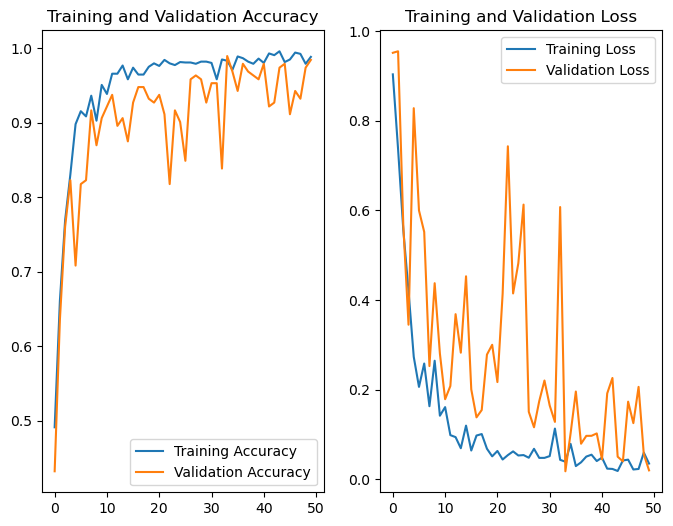

In [45]:
plt.figure(figsize=(8, 6))
plt.subplot(1, 2, 1)
plt.plot(range(epochs), acc, label='Training Accuracy')
plt.plot(range(epochs), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(epochs), loss, label='Training Loss')
plt.plot(range(epochs), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Prediction

In [46]:
import numpy as np
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 51ms/step


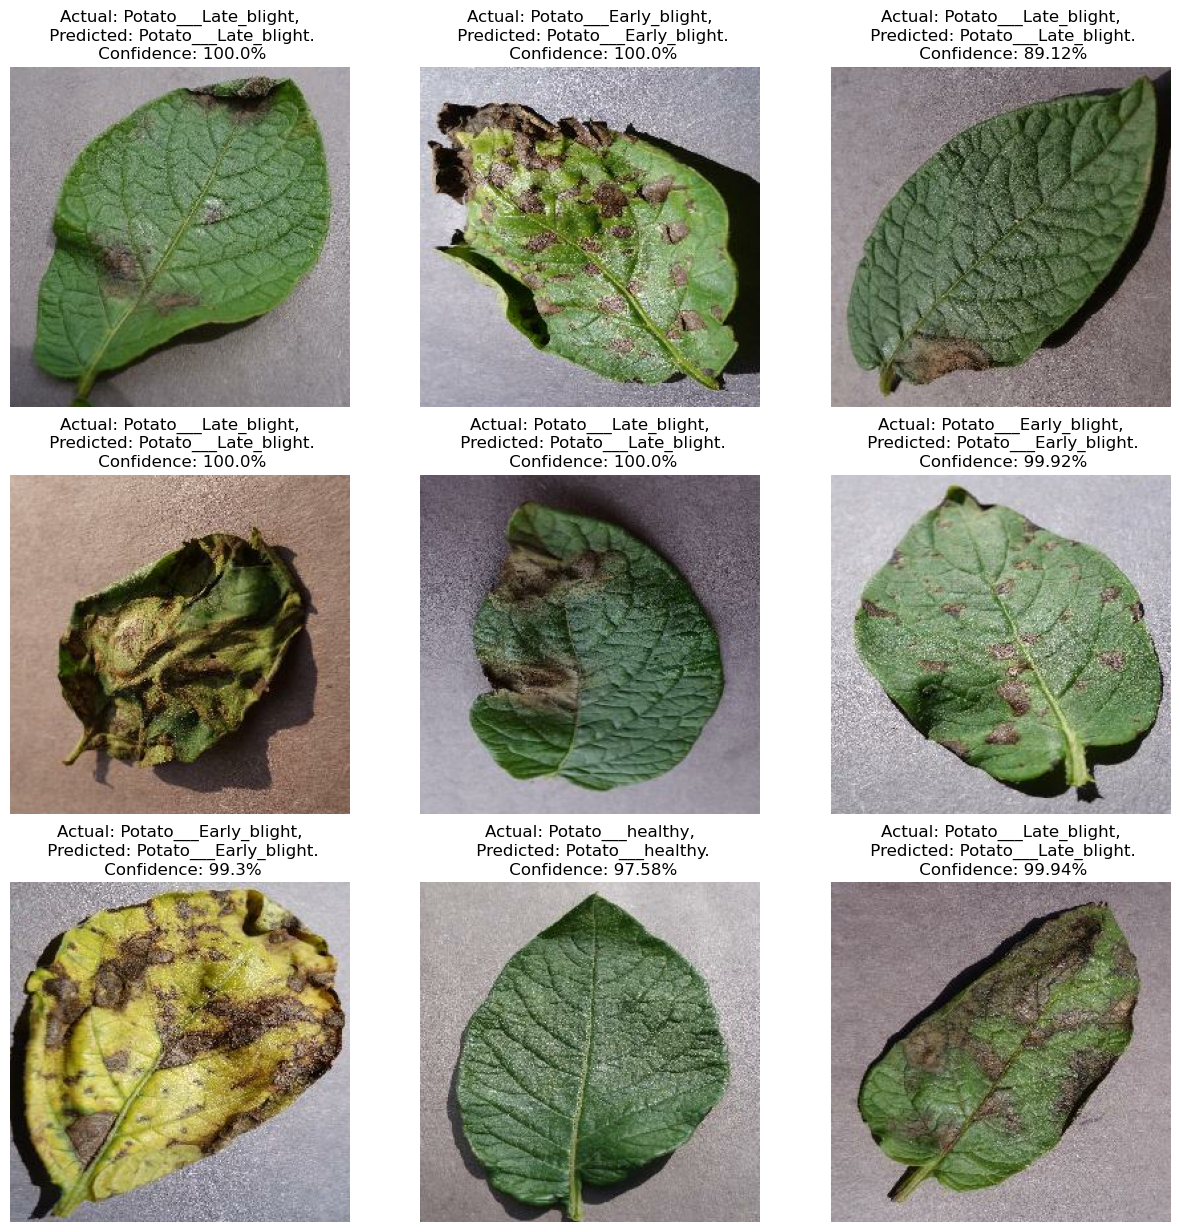

In [47]:
plt.figure(figsize=(15, 15))
for images, labels in test_data.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

## Saving the Model
it saves the new version of model

In [56]:
import os
model.save(f"models/model1")

INFO:tensorflow:Assets written to: models/model1\assets


INFO:tensorflow:Assets written to: models/model1\assets


# Tomato

In [6]:
data2 = tf.keras.preprocessing.image_dataset_from_directory(
    "tamato-images", shuffle = True, image_size = (ImageSize, ImageSize), batch_size = BatchSize
)

Found 16011 files belonging to 10 classes.


In [8]:
class_names2 = data2.class_names
class_names2

['Tomato_Bacterial_spot',
 'Tomato_Early_blight',
 'Tomato_Late_blight',
 'Tomato_Leaf_Mold',
 'Tomato_Septoria_leaf_spot',
 'Tomato_Spider_mites_Two_spotted_spider_mite',
 'Tomato__Target_Spot',
 'Tomato__Tomato_YellowLeaf__Curl_Virus',
 'Tomato__Tomato_mosaic_virus',
 'Tomato_healthy']

In [9]:
train2, val2, test2 = train_test_split(data2)

In [10]:
print(len(train2), len(val2), len(test2))

400 50 51


In [11]:
train2 = train2.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val2 = val2.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test2 = test2.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [12]:
train2 = train2.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [13]:
input_shape = (BatchSize, ImageSize, ImageSize, channels)
n_classes = 10

model2 = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model2.build(input_shape=input_shape)

In [14]:
model2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (32, 127, 127, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 62, 62, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (32, 60, 60, 64)         

In [14]:
model2.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [15]:
history = model2.fit(
    train2,
    batch_size=BatchSize,
    validation_data=val2,
    verbose=1,
    epochs=50,
)

Epoch 1/50
400/400 [==============================] - 614s 1s/step - loss: 1.7654 - accuracy: 0.3672 - val_loss: 1.7092 - val_accuracy: 0.4400
Epoch 2/50
400/400 [==============================] - 453s 1s/step - loss: 1.0812 - accuracy: 0.6169 - val_loss: 0.7612 - val_accuracy: 0.7169
Epoch 3/50
400/400 [==============================] - 497s 1s/step - loss: 0.6996 - accuracy: 0.7536 - val_loss: 0.7251 - val_accuracy: 0.7406
Epoch 4/50
400/400 [==============================] - 512s 1s/step - loss: 0.5287 - accuracy: 0.8089 - val_loss: 0.4253 - val_accuracy: 0.8406
Epoch 5/50
400/400 [==============================] - 652s 2s/step - loss: 0.4405 - accuracy: 0.8398 - val_loss: 0.4188 - val_accuracy: 0.8438
Epoch 6/50
400/400 [==============================] - 869s 2s/step - loss: 0.3855 - accuracy: 0.8607 - val_loss: 0.5636 - val_accuracy: 0.8056
Epoch 7/50
400/400 [==============================] - 885s 2s/step - loss: 0.3353 - accuracy: 0.8795 - val_loss: 0.5076 - val_accuracy: 0.8238

In [17]:
import os
model2.save(f"models/model2")

INFO:tensorflow:Assets written to: models/model2\assets


INFO:tensorflow:Assets written to: models/model2\assets


# PEPPER

In [18]:
data3 = tf.keras.preprocessing.image_dataset_from_directory(
    "pepper-images", shuffle = True, image_size = (ImageSize, ImageSize), batch_size = BatchSize
)

Found 2475 files belonging to 2 classes.


In [19]:
class_names3 = data3.class_names
class_names3

['Pepper__bell___Bacterial_spot', 'Pepper__bell___healthy']

In [20]:
train3, val3, test3 = train_test_split(data3)

In [22]:
print(len(train3), len(val3), len(test3))

62 7 9


In [23]:
train3 = train3.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val3 = val3.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test3 = test3.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [24]:
train3 = train3.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [25]:
input_shape = (BatchSize, ImageSize, ImageSize, channels)
n_classes = 2

model3 = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model3.build(input_shape=input_shape)

In [26]:
model2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 127, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 62, 62, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 64)       

In [27]:
model3.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [28]:
history = model3.fit(
    train3,
    batch_size=BatchSize,
    validation_data=val3,
    verbose=1,
    epochs=50,
)

Epoch 1/50
62/62 [==============================] - 169s 3s/step - loss: 0.5519 - accuracy: 0.6964 - val_loss: 0.3217 - val_accuracy: 0.8616
Epoch 2/50
62/62 [==============================] - 141s 2s/step - loss: 0.1948 - accuracy: 0.9282 - val_loss: 0.1525 - val_accuracy: 0.9420
Epoch 3/50
62/62 [==============================] - 132s 2s/step - loss: 0.1353 - accuracy: 0.9516 - val_loss: 0.1205 - val_accuracy: 0.9777
Epoch 4/50
62/62 [==============================] - 135s 2s/step - loss: 0.0741 - accuracy: 0.9776 - val_loss: 0.0659 - val_accuracy: 0.9821
Epoch 5/50
62/62 [==============================] - 127s 2s/step - loss: 0.0525 - accuracy: 0.9862 - val_loss: 0.1318 - val_accuracy: 0.9509
Epoch 6/50
62/62 [==============================] - 114s 2s/step - loss: 0.0503 - accuracy: 0.9852 - val_loss: 0.1211 - val_accuracy: 0.9554
Epoch 7/50
62/62 [==============================] - 139s 2s/step - loss: 0.0457 - accuracy: 0.9888 - val_loss: 0.0614 - val_accuracy: 0.9866
Epoch 8/50
62

In [29]:
model3.save(f"models/model3")

INFO:tensorflow:Assets written to: models/model3\assets


INFO:tensorflow:Assets written to: models/model3\assets
